# Depth Estimation using Stereo Vision

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-6-7-8/embed" width="100%" height="500" title="Test Title" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

## What is Stereo Vision?

Stereo vision is a **classical computer vision technique** that mimics human binocular vision to perceive depth. Just like your left and right eyes capture slightly different views of the world, two cameras placed at slightly different positions observe the same scene from different angles.

> **Key Idea:** The difference in the position of the same point in two images is called **disparity**, and it is the foundation for estimating depth.

---

## Why Do We Need Depth Estimation?

Depth estimation answers a fundamental question in computer vision:  
> _"How far is each point in the scene from the camera?"_

This is critical for:
- **Autonomous vehicles:** Understanding the 3D layout of the road.
- **Robotics:** Navigating and interacting with objects.
- **Augmented Reality (AR):** Anchoring virtual objects realistically.
- **3D Reconstruction:** Building point clouds or 3D meshes from images.

---

## How Does Stereo Vision Work?

Stereo vision works through these main steps:

| Step | Description |
|------|--------------|
| 1 | **Capture Images:** Use two cameras with a known baseline (distance between them). |
| 2 | **Rectify Images:** Align the images so that corresponding points lie on the same horizontal line (epipolar constraint). |
| 3 | **Find Correspondences:** Match each pixel in the left image to its counterpart in the right image. |
| 4 | **Compute Disparity:** Measure how much a point shifts between the two images. |
| 5 | **Estimate Depth:** Use the disparity and camera parameters to calculate depth. |

---

## The Basic Depth Formula

> **Depth ($Z$)** is inversely proportional to **Disparity ($d$)**.

![](figures/stereo-vision-simple.png)

The core relationship is:

$$
Z = \frac{f \cdot T}{d}
$$

**Where:**
- $Z = $ Depth of the point.
- $f = $ Focal length of the camera.
- $T = $ Baseline distance between the two cameras.
- $d = x_l - x_r$ Disparity (pixel difference).

> **Note:** The greater the disparity, the closer the object is.

---

## Epipolar Geometry

![](figures/epipolar-geometry.png)

## Example: Human Vision

Humans naturally perform stereo depth estimation:
- Our eyes are about 6–7 cm apart.
- The brain matches points from each eye’s image.
- It computes disparity and infers depth almost instantly.

---

## Advantages of Classical Stereo Vision

- **Passive:** No need for active sensors like LiDAR.
- **Low Cost:** Uses simple cameras.
- **Dense Depth:** Provides pixel-wise depth map.

---

## Challenges in Stereo Vision

> **Challenges**
> - **Textureless Regions:** Hard to find matches.
> - **Occlusions:** Some points visible in one image may be hidden in the other.
> - **Lighting Changes:** Shadows and reflections can confuse matching.
> - **Calibration:** Requires precise knowledge of camera parameters.

---

## When to Use Stereo Vision

Stereo vision is ideal when:
- You have good textured scenes.
- You need dense depth information.
- You can ensure well-calibrated, synchronized cameras.

---

## Next Steps

In the upcoming sections, we will cover:
- **Epipolar Geometry**
- **Fundamental & Essential Matrices**
- **Rectification**
- **Block Matching Algorithms**
- **Depth Map Visualization**
- **Practical Python Implementations**

Let’s dive deeper into the geometry that makes all this possible.

# 1. Fetch Stereo Images

We use two stereo images (`Left` and `Right`) from the Tsukuba stereo dataset.
In **offline mode**, we use `imageio` to fetch them directly from a URL.

The same images are used for both online and offline modes to ensure consistent results.

In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imageio.v3 as iio

from io import BytesIO

# Async Pyodide fetch function
async def read_image_online(url: str) -> np.ndarray:
    from pyodide.http import pyfetch
    resp = await pyfetch(url=url, method="GET")
    data = BytesIO(await resp.bytes())
    return iio.imread(data, index=None)

# Offline standard fetch function
def read_image_offline(url: str) -> np.ndarray:
    return iio.imread(url, index=None)

# Async load & show for online
async def load_and_show_online(left_url, right_url):
    imgL = await read_image_online(left_url)
    imgR = await read_image_online(right_url)
    if imgL.ndim == 3:
        imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    if imgR.ndim == 3:
        imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title("Left Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title("Right Image")
    plt.axis('off')
    plt.show()

    return imgL, imgR

# Load & show for offline
def load_and_show_offline(left_url, right_url):
    imgL = read_image_offline(left_url)
    imgR = read_image_offline(right_url)
    if imgL.ndim == 3:
        imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    if imgR.ndim == 3:
        imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title("Left Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title("Right Image")
    plt.axis('off')
    plt.show()

    return imgL, imgR

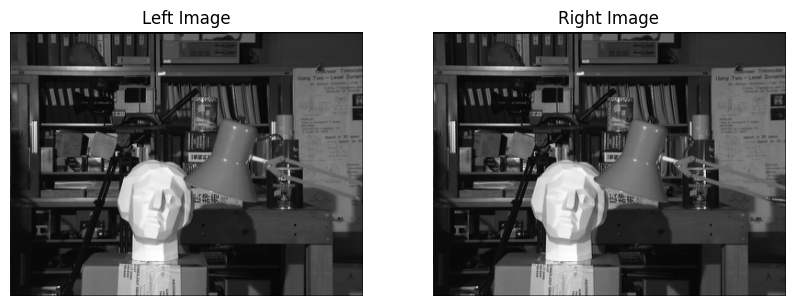

In [ ]:
# Set flag and stereo pair URLs
online = True  # Toggle True/False

LEFT = "https://raw.githubusercontent.com/canberkgurel/DisparityMapfromStereoPair/master/tsukuba_l.png"
RIGHT = "https://raw.githubusercontent.com/canberkgurel/DisparityMapfromStereoPair/master/tsukuba_r.png"

if online:
    imgL, imgR = await load_and_show_online(LEFT, RIGHT)
else:
    imgL, imgR = load_and_show_offline(LEFT, RIGHT)

# 2. Detect Corners

We use the `detect_corners` function to find good feature points (corners) in both images.
These corners will be used to estimate correspondences and the Fundamental Matrix.

In [10]:
def detect_corners(img: np.ndarray,
                   max_corners: int = 500,
                   quality: float = 0.01,
                   min_dist: float = 10.0) -> np.ndarray:
    corners = cv.goodFeaturesToTrack(img, max_corners, quality, min_dist)
    return corners.reshape(-1, 2)

# Detect corners in both images
cL = detect_corners(imgL)
cR = detect_corners(imgR)

print(f"Detected {len(cL)} corners in Left image.")
print(f"Detected {len(cR)} corners in Right image.")

Detected 336 corners in Left image.
Detected 342 corners in Right image.


# 3. Extract Image Patches

Around each detected corner, we extract a small square patch.
These patches help us compare local regions and match points between the two images.

In [11]:
def extract_patches(img: np.ndarray,
                    pts: np.ndarray,
                    patch_size: int = 21) -> tuple[np.ndarray, np.ndarray]:
    half = patch_size // 2
    h, w = img.shape
    patches, valid = [], []
    for x, y in pts.astype(int):
        if y - half < 0 or y + half >= h or x - half < 0 or x + half >= w:
            continue
        patches.append(img[y - half:y + half + 1, x - half:x + half + 1].flatten())
        valid.append((x, y))
    return np.array(patches), np.array(valid)

# Extract patches
pL, ptsL = extract_patches(imgL, cL)
pR, ptsR = extract_patches(imgR, cR)

print(f"Extracted {len(pL)} valid patches from Left image.")
print(f"Extracted {len(pR)} valid patches from Right image.")

Extracted 286 valid patches from Left image.
Extracted 287 valid patches from Right image.


# 4. Match Patches

For each patch in the Left image, find the most similar patch in the Right image.
We use the Sum of Squared Differences (SSD) to measure similarity.

In [12]:
def match_patches(p1, pts1, p2, pts2, max_ssd: float = 1e6):
    m1, m2 = [], []
    for i, d1 in enumerate(p1):
        errs = np.sum((p2 - d1)**2, axis=1)
        j = np.argmin(errs)
        if errs[j] < max_ssd:
            m1.append(pts1[i])
            m2.append(pts2[j])
    return np.array(m1), np.array(m2)

# Match features
pts1, pts2 = match_patches(pL, ptsL, pR, ptsR)
print(f"Matched {len(pts1)} feature pairs.")

Matched 286 feature pairs.


# 5. Estimate Fundamental Matrix using RANSAC

Use the Eight-Point Algorithm with RANSAC to robustly estimate the Fundamental Matrix (F).
This matrix describes the epipolar geometry between the two views.

In [13]:
def normalize_points(pts):
    mean = pts.mean(axis=0)
    s = np.sqrt(2) / pts.std()
    T = np.array([[s, 0, -s * mean[0]], [0, s, -s * mean[1]], [0, 0, 1]])
    ph = np.hstack([pts, np.ones((len(pts), 1))])
    pn = (T @ ph.T).T
    return pn[:, :2], T

def eight_point_algorithm(pts1, pts2):
    p1n, T1 = normalize_points(pts1)
    p2n, T2 = normalize_points(pts2)
    A = np.zeros((len(pts1), 9))
    for i, (x1, y1) in enumerate(p1n):
        x2, y2 = p2n[i]
        A[i] = [x1 * x2, x1 * y2, x1,
                y1 * x2, y1 * y2, y1,
                x2, y2, 1]
    _, _, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
    U, S, Vt2 = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vt2
    F = T2.T @ F @ T1
    return F / F[2, 2]

def compute_fundamental_ransac(pts1, pts2, iters=500, tol=1e-3):
    best_in, bestF = [], None
    N = len(pts1)
    h1 = np.hstack([pts1, np.ones((N, 1))])
    h2 = np.hstack([pts2, np.ones((N, 1))])
    for _ in range(iters):
        idx = np.random.choice(N, 8, replace=False)
        Fc = eight_point_algorithm(pts1[idx], pts2[idx])
        l2 = (Fc @ h1.T).T
        l1 = (Fc.T @ h2.T).T
        num = np.sum(h2 * (Fc @ h1.T).T, axis=1) ** 2
        denom = l2[:, 0]**2 + l2[:, 1]**2 + l1[:, 0]**2 + l1[:, 1]**2
        errs = num / denom
        inliers = np.where(errs < tol)[0]
        if len(inliers) > len(best_in):
            best_in, bestF = inliers, Fc
    if bestF is None:
        raise RuntimeError("RANSAC failed")
    Fref = eight_point_algorithm(pts1[best_in], pts2[best_in])
    mask = np.zeros(N, bool)
    mask[best_in] = True
    return Fref / Fref[2, 2], mask

# Estimate Fundamental Matrix
F, mask = compute_fundamental_ransac(pts1, pts2)
print("Estimated Fundamental Matrix (F):\n", F)

Estimated Fundamental Matrix (F):
 [[ 1.91885542e-34 -8.52778334e-19  1.08945687e-16]
 [ 4.71454216e-19  3.24828766e-18 -1.80739425e-01]
 [-9.95691761e-17  1.73685384e-01  1.00000000e+00]]


# 6. Visualize Epipolar Lines

For matched points, draw the corresponding epipolar lines on both images.
Correct matches should lie close to their corresponding epipolar lines.

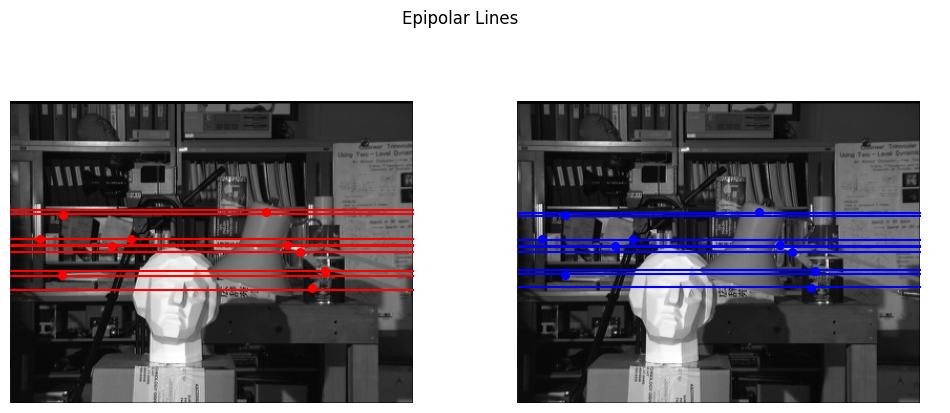

In [14]:
def draw_epipolar_lines(img1, img2, F, pts1, pts2, mask, max_lines=10):
    in1 = pts1[mask]
    in2 = pts2[mask]
    k = min(len(in1), max_lines)
    in1, in2 = in1[:k], in2[:k]
    l1 = (F.T @ np.hstack([in2, np.ones((k, 1))]).T).T
    l2 = (F @ np.hstack([in1, np.ones((k, 1))]).T).T

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, img, lines, pts, col in zip(
        axes, [img1, img2], [l1, l2], [in1, in2], ['r', 'b']
    ):
        ax.imshow(img, cmap='gray')
        h, w = img.shape
        for (a, b, c), (x, y) in zip(lines, pts):
            x0, x1 = 0, w
            y0 = -(a * x0 + c) / b
            y1 = -(a * x1 + c) / b
            ax.plot([x0, x1], [y0, y1], col)
            ax.scatter(x, y, c=col, s=30)
        ax.axis('off')
    plt.suptitle("Epipolar Lines")
    plt.show()

# Draw epipolar lines
draw_epipolar_lines(imgL, imgR, F, pts1, pts2, mask)

# 7. Compute Dense Disparity Map

Finally, compute the dense disparity map using:
- A **custom block matching implementation**, and
- OpenCV’s `StereoBM` algorithm for comparison.

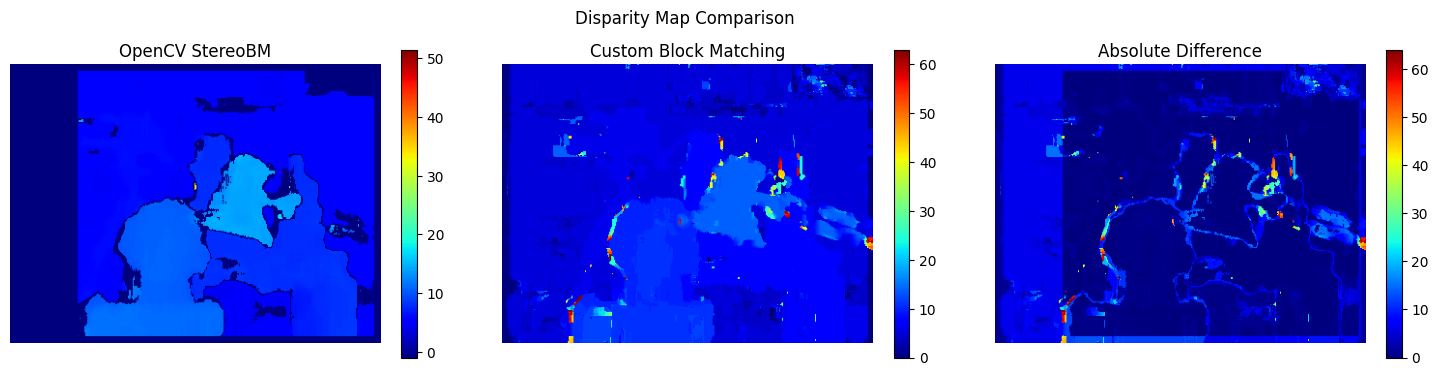

MAE: 2.7334013
RMSE: 5.9511433


In [17]:
def compute_dense_disparity_fast(imgL, imgR, max_disp=64, block_size=9):
    h, w = imgL.shape
    disp = np.zeros((h, w), np.float32)
    best = np.full((h, w), np.inf, np.float32)
    for d in range(max_disp):
        shifted = np.zeros_like(imgR)
        shifted[:, d:] = imgR[:, :w - d]
        cost = (imgL.astype(np.float32) - shifted.astype(np.float32))**2
        cost = cv.boxFilter(cost, -1, (block_size, block_size), normalize=False)
        m = cost < best
        disp[m] = d
        best[m] = cost[m]
    return disp

# Compute custom and OpenCV disparity maps
disp_custom = compute_dense_disparity_fast(imgL, imgR, max_disp=64, block_size=9)
stereo = cv.StereoBM_create(numDisparities=64, blockSize=15)
disp_cv = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Compare
diff = np.abs(disp_cv - disp_custom)
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for ax, mat, title in zip(axs, [disp_cv, disp_custom, diff],
                          ["OpenCV StereoBM", "Custom Block Matching", "Absolute Difference"]):
    im = ax.imshow(mat, cmap='jet')
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.suptitle("Disparity Map Comparison")
plt.show()

print("MAE:", np.mean(diff))
print("RMSE:", np.sqrt(np.mean(diff**2)))

This wraps up the **classical stereo vision pipeline**:
1. Capture stereo images  
2. Detect features  
3. Match features  
4. Compute the Fundamental Matrix and epipolar geometry  
5. Compute a dense disparity map  
6. Estimate depth

These core principles form the foundation for modern stereo depth estimation systems.